Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

In [1]:
import torch, pywt, csv, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import reader1 as rd
import utilerias as utls
from NARNN import NARNN 
criterion = nn.MSELoss()
redes = {"red_A1" : 'models/red_A1.pth',
         "red_D1" : 'models/red_D1.pth',
         "red_D2" : 'models/red_D2.pth',
         "red_D3" : 'models/red_D3.pth',
         "red_D4" : 'models/red_D4.pth',
         "red_D5" : 'models/red_D5.pth'}

/home/miguel/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-22 21:28:54.900505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 21:28:55.164409: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 21:28:55.164451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 21:28:55.165604: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

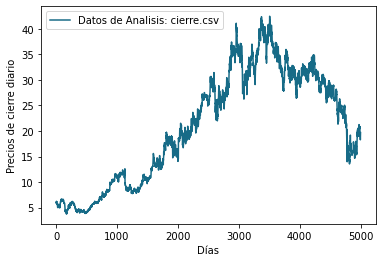

In [2]:

# Abrir el archivo CSV en modo lectura

#DATOS = 'C_Egipto_diario.csv'
DATOS = 'cierre.csv'#Grupo Financiero Inbursa

cierre_inbursa = rd.leer_archivo('cierre.csv')
cierre = rd.leer_archivo(DATOS)

#se convierten todos los valores a flotantes
cierre = cierre.astype(float)
x = np.arange(1, (cierre.shape[0]+1))

# Crear un gráfico de línea con los valores de x, y
plt.plot(range(len(cierre)), cierre, label=f"Datos de Analisis: {DATOS}", color='#176B87')
plt.xlabel('Días')
plt.ylabel('Precios de cierre diario')
plt.legend()

# Mostrar el gráfico
plt.show()

#Eleccion de Mother Wavelet

Se elige las mother wavelets dependiendo de las caracteristicas de la serie de tiempo que se va a analizar. Para series que impliquen cambios no periodicos y repentinos es recomendable usar Haar ya que responde bien a estos cambios repentinos.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, el mother wavelet debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada 

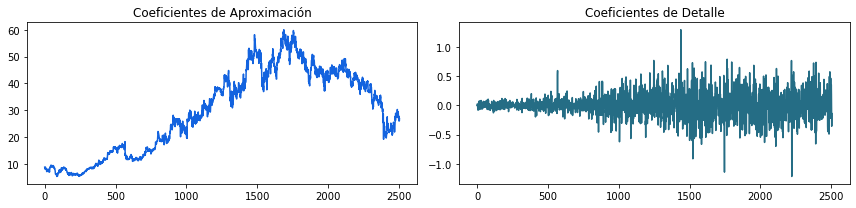

In [3]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
wavelet = 'bior3.5'
(cA, cD) = pywt.dwt(cierre.tolist(), wavelet)

# # cA.size = 2505, cD.size = 2505
# plt.plot(x[:len(cA)], cA[:len(cA)])
# plt.show()

# plt.plot(x[:len(cD)], cD[:len(cD)])
# plt.show()

plt.figure(figsize=(12, 3))

aprox_coef = True
index = 1

for _ in [cA, cD]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    # plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


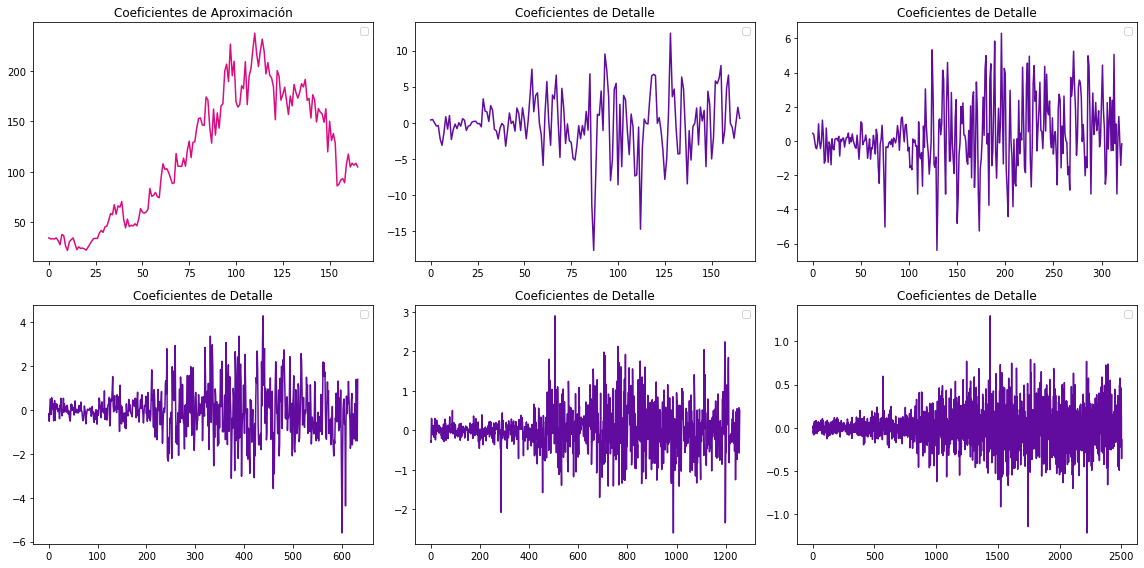

In [4]:
#Se realiza el proceso 5 veces
cierre_prueba = cierre[int(len(cierre) * 0.7):]
coeffs = pywt.wavedec(cierre, wavelet, level=5)

coeffs_prueba = pywt.wavedec(cierre_prueba, wavelet, level=5)

cA = coeffs[0]
# plt.plot(x[:len(cA)], cA)
# plt.show()

cD_1 = coeffs[1]
cD_2 = coeffs[2]
cD_3 = coeffs[3]
cD_4 = coeffs[4]
cD_5 = coeffs[5]

plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in coeffs:
    plt.subplot(2, 3, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

# plt.plot(range(len(cD_2)), cD_2)
# plt.show()

# plt.plot(range(len(cD_3)), cD_3)
# plt.show()

# plt.plot(range(len(cD_4)), cD_4)
# plt.show()

# plt.plot(range(len(cD_5)), cD_5)
# plt.show()


In [5]:
A5=coeffs[0]#coeficientes de analisis
D1=coeffs[1]#coeficientes de detalle
D2=coeffs[2]
D3=coeffs[3]
D4=coeffs[4]
D5=coeffs[5]

#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
coeffs_n = [utls.normalizar(vect) for vect in coeffs]
coeffs_n_prueba = [utls.normalizar(vect) for vect in coeffs_prueba]

#Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
#componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena


entrenamiento,prueba,validacion = utls.generar_conjuntos(coeffs_n,False,5)
#la de abajo es una prueba
#entrenamiento,prueba,validacion = utls.generar_conjuntos([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]],False,1)

In [6]:
#print(prueba)
# for i in prueba:
#     print(len(i))
# prueba_8_1 = [[],[],[],[],[],[]]
# for e in range(6):
#     prueba_8_1[e] = utls.corrimiento_t_1(prueba[e],9)
# print(prueba_8_1[0])

In [7]:
red_A1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_A1.load_state_dict(torch.load(redes["red_A1"]))
red_A1.eval()

red_D1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D1.load_state_dict(torch.load(redes["red_D1"]))
red_D1.eval()

red_D2 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D2.load_state_dict(torch.load(redes["red_D2"]))
red_D2.eval()

red_D3 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D3.load_state_dict(torch.load(redes["red_D3"]))
red_D3.eval()

red_D4 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D4.load_state_dict(torch.load(redes["red_D4"]))
red_D4.eval()

red_D5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D5.load_state_dict(torch.load(redes["red_D5"]))
red_D5.eval()

networks = [red_A1,red_D1,red_D2,red_D3,red_D4,red_D5]

#entradas ya procesadas
entrenamiento_8_1 = [[],[],[],[],[],[]]
prueba_8_1 = [[],[],[],[],[],[]]
serie_c = [[],[],[],[],[],[]]
coeffs_n_prueba_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)
    prueba_8_1[e] = utls.corrimiento_t_1(prueba[e],9)
    serie_c[e] = utls.corrimiento_t_1(coeffs_n[e],9)
    coeffs_n_prueba_8_1[e] = utls.corrimiento_t_1(coeffs_n_prueba[e],9)
    
#la forma de la entrada de la red neuronal
print(entrenamiento_8_1[0][0][:8])
print(len(entrenamiento_8_1[0]))
#salida = red(entrenamiento_8_1[0][:, :8])
#print(salida)

tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728])
108


In [8]:

#params = red_A1.parameters()
#--utls.entrena(red_A1,0,entrenamiento_8_1,50)
EPOCAS = 100
# utls.entrena_LM(red_A1,0,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM(red_D1,1,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM(red_D2,2,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM(red_D3,3,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM(red_D4,4,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM(red_D5,5,entrenamiento_8_1,EPOCAS)

In [9]:
#print("paramtros despues: " + str([i for i in red_A1.parameters()][0]))
#print(red_A1(torch.Tensor([0.8709, 0.6840, 0.6600, 0.6713, 0.7581, 0.7445, 0.8692, 0.6714])))

In [10]:
#entradas ya procesadas
# entrenamiento_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
# for e in range(6):
#     entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

#pruebas_ordenadas = []

# for e in range(6):
#     entrenamiento_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

#for c_pruebas in entrenamiento:#entre
    #print("corrimiento: " + str(utls.corrimiento_t_1(c_pruebas,9)))
 #   pruebas_ordenadas.append(utls.corrimiento_t_1(c_pruebas,9))#prueba[0] es el conjunto de prueba para cada red
#pruebas = forma_entrada(prueba[0],9)#prueba[0] es el conjunto de prueba para A1
#print(utls.genera_prediccion_1(pruebas_ordenadas[0],red_A1))
#print(len(utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]))
#print(entrenamiento[0])


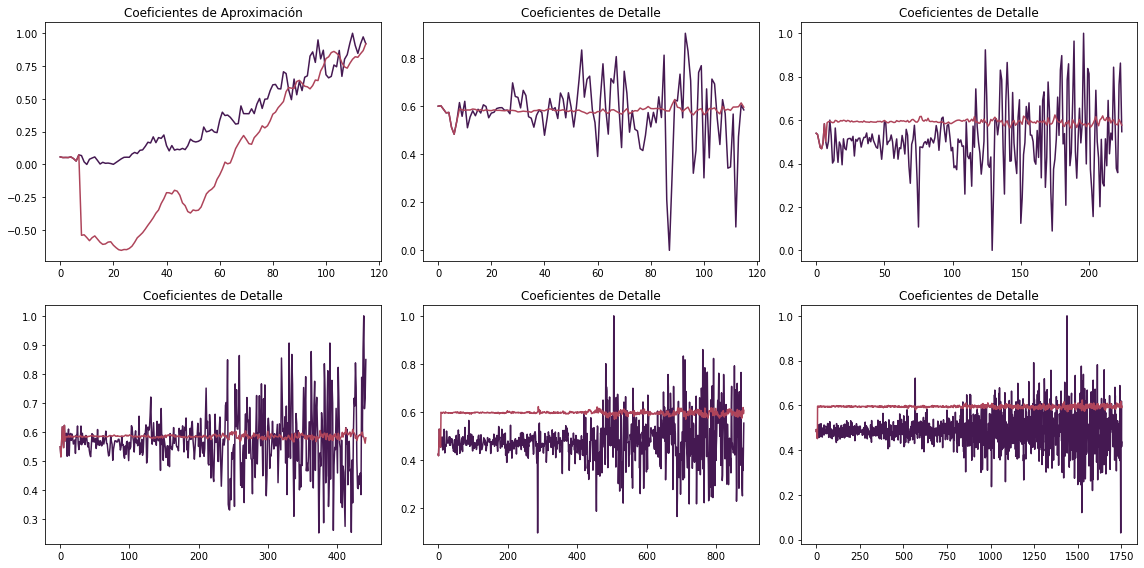

In [11]:
#Se grafica el conjunto de entrenamiento
# plt.plot(range(len(entrenamiento[0])), entrenamiento[0])
# plt.plot(range(len(entrenamiento[0])), utls.genera_prediccion_1(entrenamiento_8_1[0],red_A1,8).detach().numpy())
# plt.show()

plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(prueba)):
    plt.subplot(2, 3, index)
    plt.plot(range(len(entrenamiento[_])), entrenamiento[_], color = '#451952') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(range(len(entrenamiento[_])), utls.genera_prediccion_1(entrenamiento_8_1[_],networks[_],8).detach().numpy(), color='#AE445A')#label=f"Datos de Analisis: {DATOS}",
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    #plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

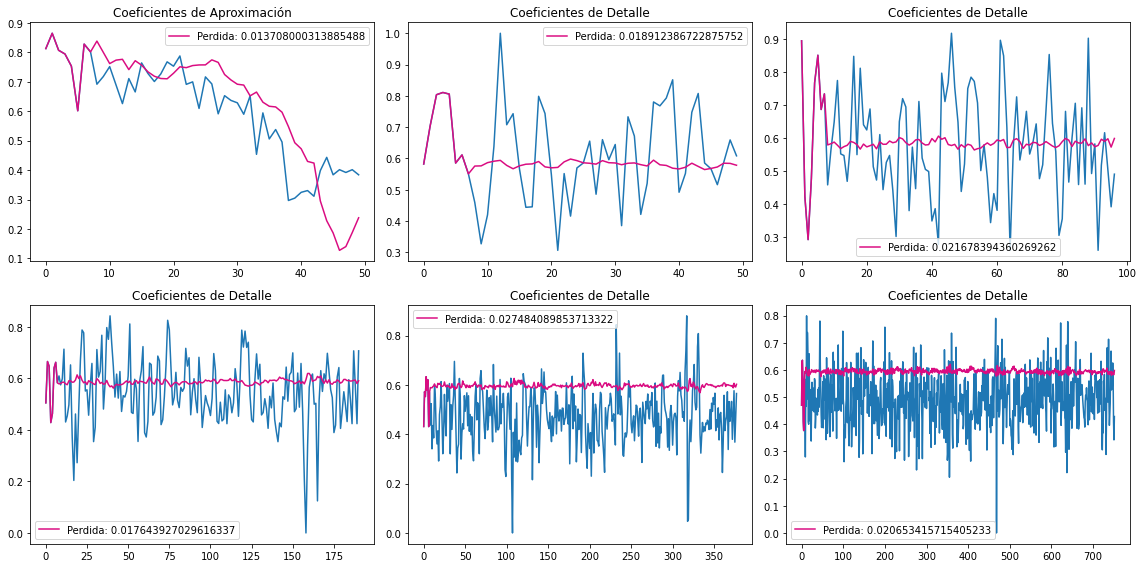

Perdidas: [tensor(0.0137, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0189, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0217, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0176, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0275, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0207, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [15]:

perdidas = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(prueba)):
    prediccion = utls.genera_prediccion_1(prueba_8_1[_],networks[_],8)
    perdidas.append(criterion(prediccion, torch.tensor(prueba[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(prueba[_])), prueba[_]) #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(range(len(prueba[_])), prediccion.detach().numpy(), label = f"Perdida: {float(perdidas[_])}" ,color='#DA0C81')#label=f"Datos de Analisis: {DATOS}",
    
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas: " + str(perdidas))

#Se grafica el conjunto de pruebas
# plt.plot(range(len(prueba[0])), prueba[0])
# plt.plot(range(len(prueba[0])), utls.genera_prediccion_1(prueba_8_1[0],red_A1,8).detach().numpy())
# plt.show(

#plt.plot(range(108), entrenamiento[0][:-8])
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()
#investigar bien la dwt y predecir la red con los corrimientos de 1, usando los datos que predice o solo los datos que le doy
#Lo que hace es generar una prediccion cada noveno día, con los datos que ya se le dan del entrenamiento, es preciso ajustar los parametros hasta que ambas series
#sean iguales
#print(prueba[0])

#Generamos el entrenamiento predictivo

In [13]:
# utls.entrena_LM_pred(red_A1,0,entrenamiento_8_1,EPOCAS) 
# utls.entrena_LM_pred(red_D1,1,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM_pred(red_D2,2,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM_pred(red_D3,3,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM_pred(red_D4,4,entrenamiento_8_1,EPOCAS)
# utls.entrena_LM_pred(red_D5,5,entrenamiento_8_1,EPOCAS)

# torch.save(red_A1.state_dict(), redes["red_A1"]) #Salvamos el estado actual del modelo
# torch.save(red_D1.state_dict(), redes["red_D1"]) 
# torch.save(red_D1.state_dict(), redes["red_D2"]) 
# torch.save(red_D1.state_dict(), redes["red_D3"]) 
# torch.save(red_D1.state_dict(), redes["red_D4"])
# torch.save(red_D1.state_dict(), redes["red_D5"]) 

# torch.save(red_A1.state_dict(), redes['models/red_A1_n.pth']) #Salvamos el estado actual del modelo
# torch.save(red_D1.state_dict(), redes['models/red_D1_n.pth']) 
# torch.save(red_D1.state_dict(), redes['models/red_D2_n.pth']) 
# torch.save(red_D1.state_dict(), redes['models/red_D3_n.pth']) 
# torch.save(red_D1.state_dict(), redes['models/red_D4_n.pth'])
# torch.save(red_D1.state_dict(), redes['models/red_D5_n.pth']) 

[tensor([0.8128, 0.8649, 0.8071, 0.7944, 0.7532, 0.6016, 0.8280, 0.8016, 0.6919]), tensor([0.8649, 0.8071, 0.7944, 0.7532, 0.6016, 0.8280, 0.8016, 0.6919, 0.7178]), tensor([0.8071, 0.7944, 0.7532, 0.6016, 0.8280, 0.8016, 0.6919, 0.7178, 0.7516]), tensor([0.7944, 0.7532, 0.6016, 0.8280, 0.8016, 0.6919, 0.7178, 0.7516, 0.6890]), tensor([0.7532, 0.6016, 0.8280, 0.8016, 0.6919, 0.7178, 0.7516, 0.6890, 0.6260]), tensor([0.6016, 0.8280, 0.8016, 0.6919, 0.7178, 0.7516, 0.6890, 0.6260, 0.7110]), tensor([0.8280, 0.8016, 0.6919, 0.7178, 0.7516, 0.6890, 0.6260, 0.7110, 0.6656]), tensor([0.8016, 0.6919, 0.7178, 0.7516, 0.6890, 0.6260, 0.7110, 0.6656, 0.7642]), tensor([0.6919, 0.7178, 0.7516, 0.6890, 0.6260, 0.7110, 0.6656, 0.7642, 0.7282]), tensor([0.7178, 0.7516, 0.6890, 0.6260, 0.7110, 0.6656, 0.7642, 0.7282, 0.7010]), tensor([0.7516, 0.6890, 0.6260, 0.7110, 0.6656, 0.7642, 0.7282, 0.7010, 0.7264]), tensor([0.6890, 0.6260, 0.7110, 0.6656, 0.7642, 0.7282, 0.7010, 0.7264, 0.7678]), tensor([0.6260,

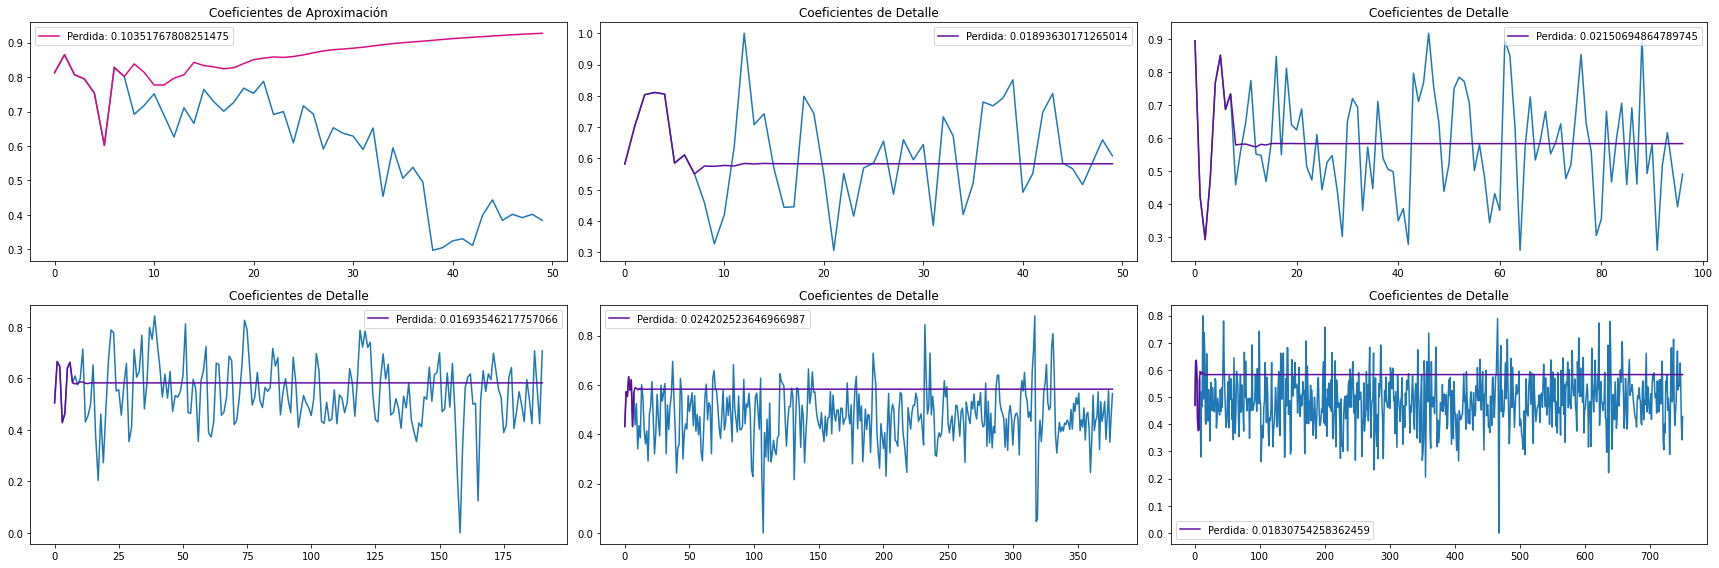

Perdidas predictivas: [tensor(0.1035, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0189, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0215, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0169, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0242, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0183, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [17]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1

# plt.plot(range(len(prueba[0])), prueba[0])
# plt.plot(range(len(prueba[0])), utls.genera_prediccion_1(prueba_8_1[0],red_A1).detach().numpy())
# plt.show()
print(prueba_8_1[0])
redes = [red_A1,red_D1,red_D2,red_D3,red_D4,red_D5]

for _ in range(len(prueba)):
    prediccion = utls.genera_prediccion_predictiva(prueba_8_1[_][0][:8],8,len(prueba_8_1[_]),redes[_])
    perdidas_predictivas.append(criterion(prediccion, torch.tensor(prueba[_])))
    plt.subplot(2, 3, index)
    plt.plot(range(len(prueba[_])), prueba[_])
    plt.plot(range(len(prueba[_])), prediccion.detach().numpy(),  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

#Se grafica el conjunto de pruebas
# plt.plot(range(len(prueba[0])), prueba[0])
# plt.plot(range(len(prueba[0])), utls.genera_prediccion_predictiva(prueba_8_1[0][0][:8],8,len(prueba_8_1[0]),red_A1).detach().numpy())
# plt.show()

#Reconstruimos la señal original usadno el conjunto de prueba

In [ ]:
cA_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[0],red_A1,8).detach().numpy()]
cD_1_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[1],red_A1,8).detach().numpy()]
cD_2_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[2],red_A1,8).detach().numpy()]
cD_3_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[3],red_A1,8).detach().numpy()]
cD_4_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[4],red_A1,8).detach().numpy()]
cD_5_p = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(coeffs_n_prueba_8_1[5],red_A1,8).detach().numpy()]

cA_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[0],red_A1,8).detach().numpy()]
cD_1_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[1],red_A1,8).detach().numpy()]
cD_2_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[2],red_A1,8).detach().numpy()]
cD_3_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[3],red_A1,8).detach().numpy()]
cD_4_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[4],red_A1,8).detach().numpy()]
cD_5_p1 = [utls.desnormalizar(vect) for vect in utls.genera_prediccion_1(prueba_8_1[5],red_A1,8).detach().numpy()]


Forma de c0: (49, 9)
Forma de c1: (49, 9)
Forma de c2: (96, 9)
Forma de c3: (189, 9)
Forma de c4: (375, 9)
Forma de c5: (747, 9)
Forma de c0: (42, 9)
Forma de c1: (42, 9)
Forma de c2: (89, 9)
Forma de c3: (183, 9)
Forma de c4: (370, 9)
Forma de c5: (744, 9)


[]

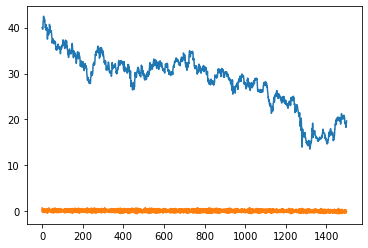

In [ ]:
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()

coeffs_p = [np.array(c) for c in [cA_p,cD_1_p,cD_2_p,cD_3_p,cD_4_p,cD_5_p]]
coeffs_p1 = [np.array(c) for c in [cA_p1,cD_1_p1,cD_2_p1,cD_3_p1,cD_4_p1,cD_5_p1]]
#print([len(i) for i in coeffs])
#print([len(i) for i in coeffs_p])

# for i, c in enumerate(coeffs_prueba):
#     print(f'Forma de c{i}: {np.shape(c)}')
for i, c in enumerate(coeffs_n_prueba_8_1):
    print(f'Forma de c{i}: {np.shape(c)}')
for i, c in enumerate(prueba_8_1):
    print(f'Forma de c{i}: {np.shape(c)}')
rec = pywt.waverec(coeffs_p, 'bior3.5')


c_prueba = cierre[int(len(cierre) * 0.7):]

plt.plot(range(len(cierre[int(len(cierre) * 0.7):])),cierre[int(len(cierre) * 0.7):]) #Señal original
plt.plot(range(len(rec)),rec) #Señal predicha

#plt.plot(range(len(cA)),cA)
plt.plot()

In [ ]:
# print(len(coeffs_n[0][int(len(coeffs_n[0]) * 0.7):]))
# print(len(coeffs_n_prueba_8_1[0]))